## INVENTA

#Prioritization of samples for chemical originality discovery
(inventa means discovered in latin)

In [47]:

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import plotly.express as px
import zipfile

import lineup_widget
from __future__ import print_function
from ipywidgets import interact, interactive, interact_manual

from sklearn.metrics import pairwise_distances
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn import preprocessing
from skbio.stats.ordination import pcoa
from skbio import OrdinationResults



In [48]:
from inventa import quant_table
from inventa import full_data
from inventa import top_ions
from inventa import annotations_conditions
from inventa import annotations
from inventa import feature_component
from inventa import literature_report
from inventa import literature_component
from inventa import similarity_conditions
from inventa import similarity_component
from inventa import sirius_classes
from inventa import search_reported_class
from inventa import is_empty
from inventa import class_component

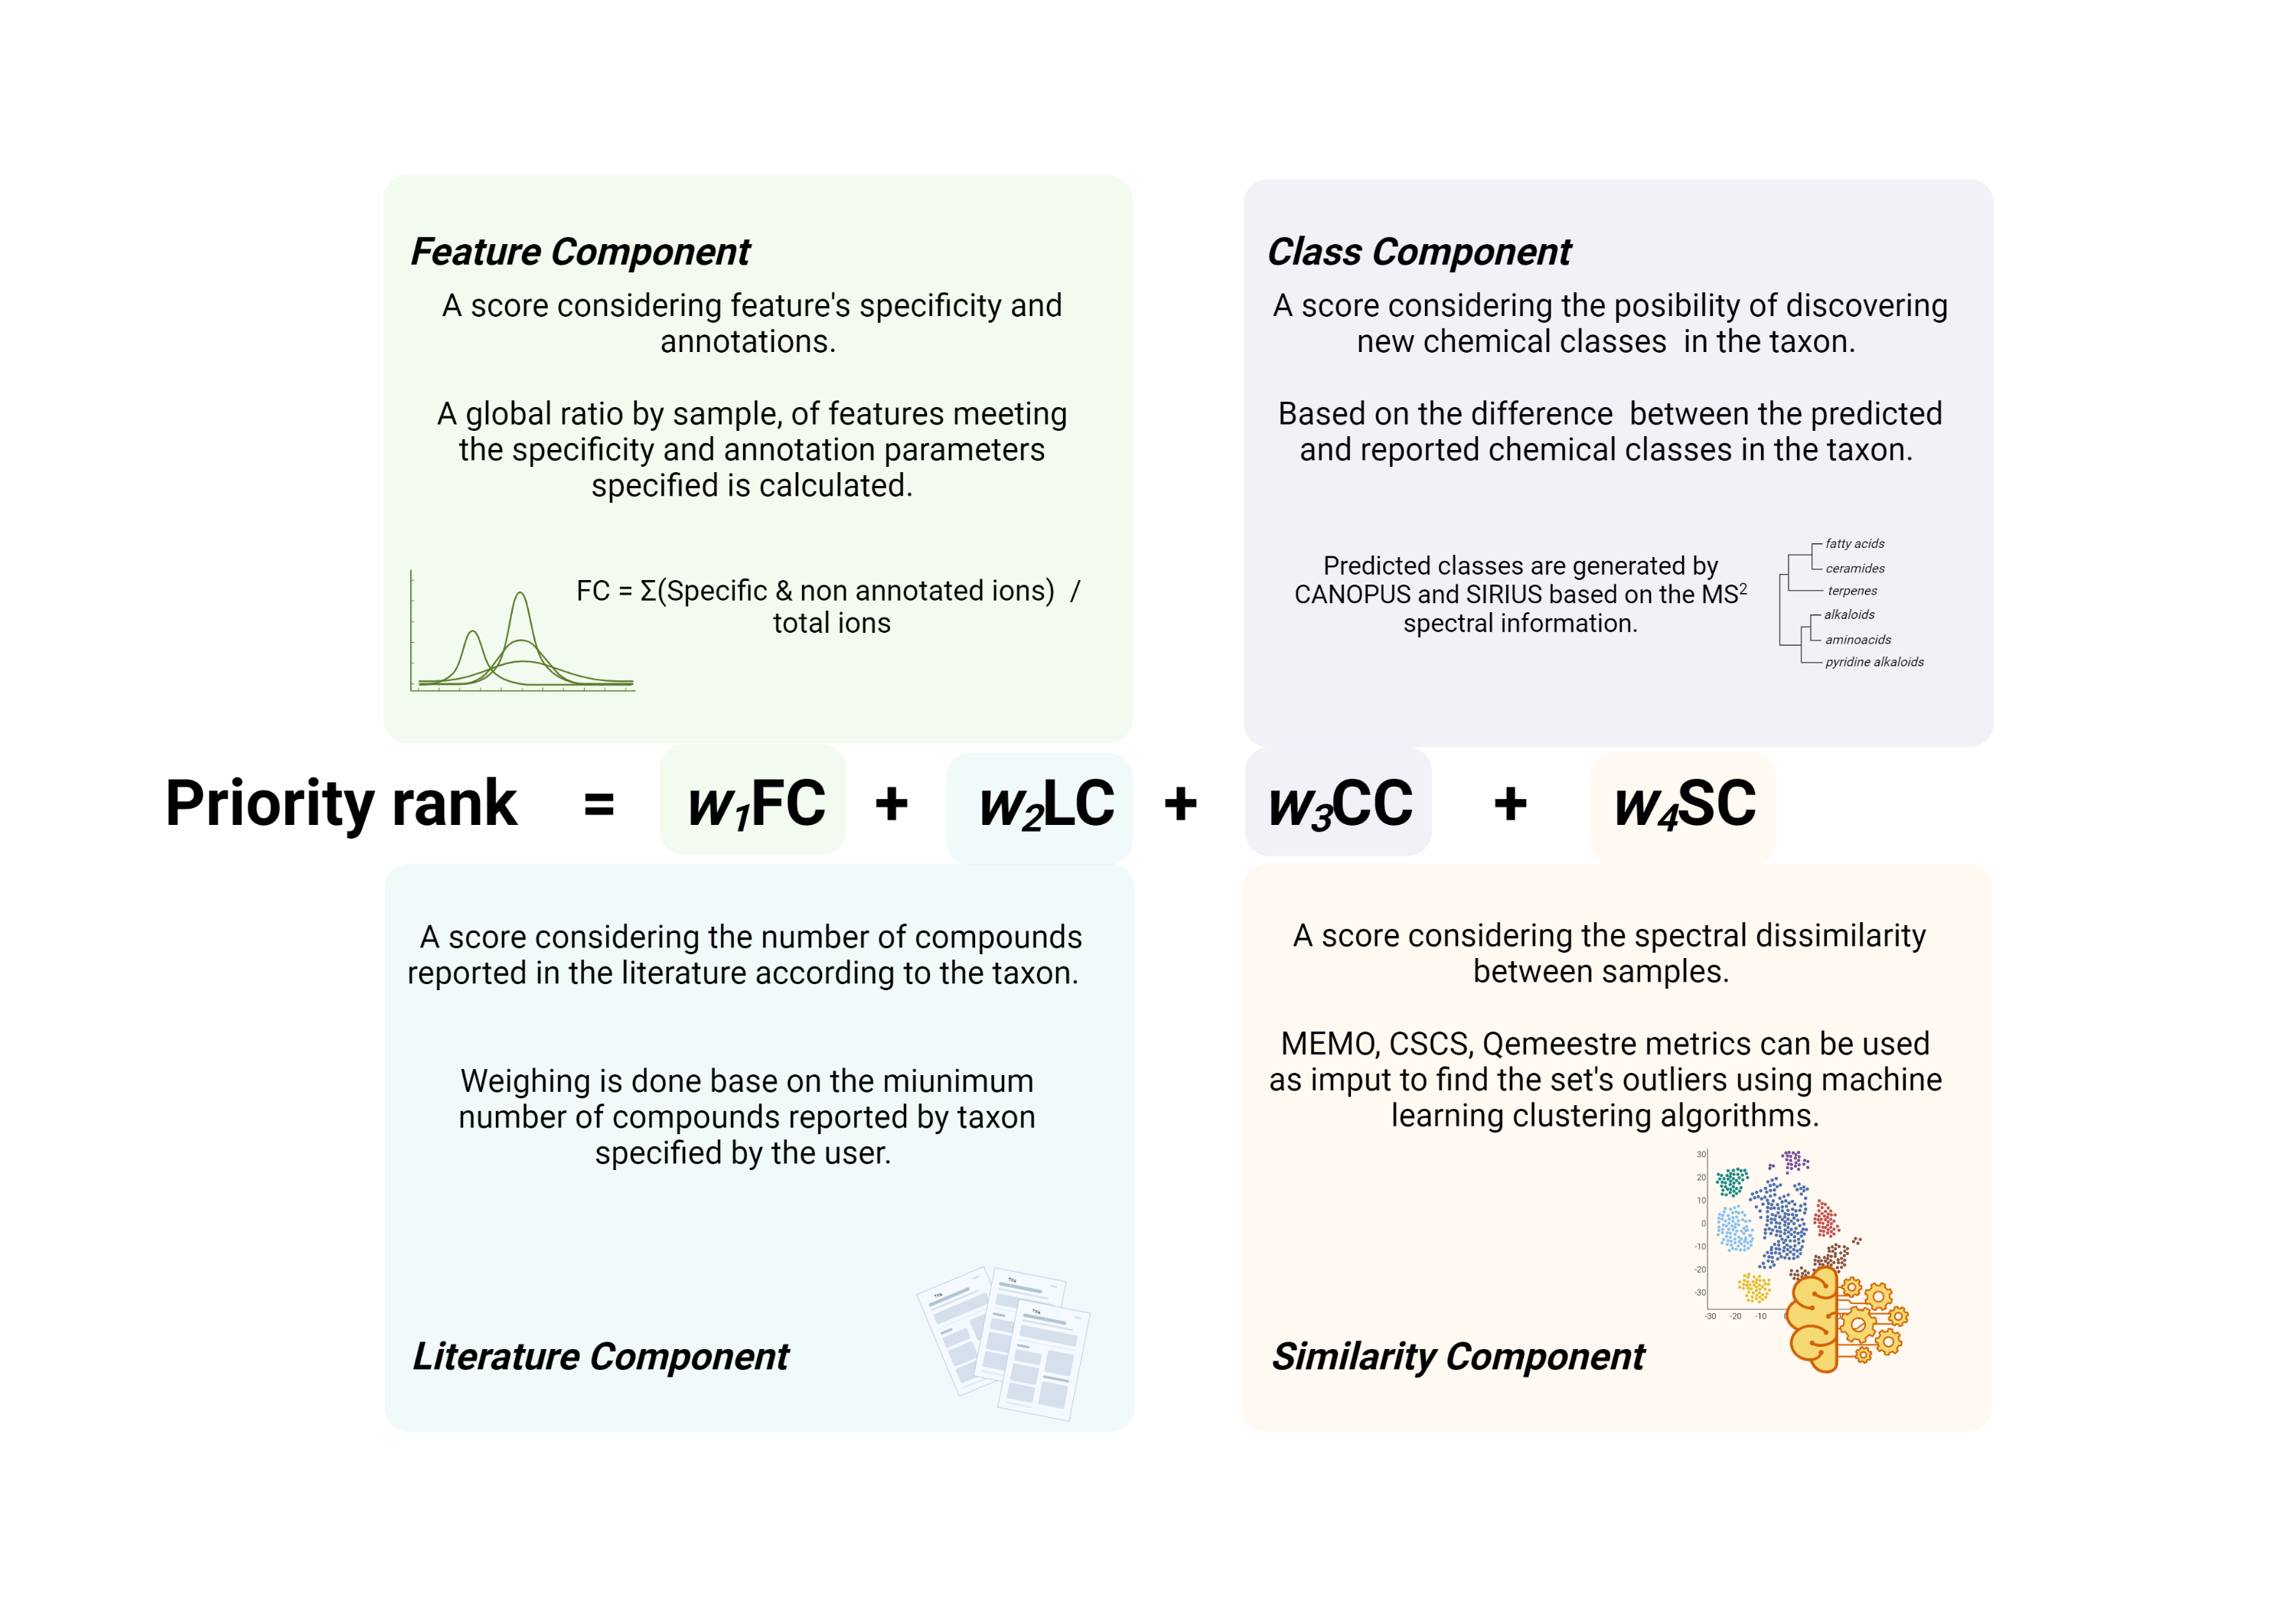

In [49]:
from PIL import Image                                                                                
img = Image.open('Priority_rank.png')
img.show() 

# Parameters to define:

In [50]:
#Input filenames: drag them in the data folder

metadata_filename = 'data/Metadata_table_PF200_pos.csv'
quantitative_data_filename = 'data/PF200_posGNPS_quant.csv'
clusterinfosummary = 'data/PF200_pos_attributes.tsv'
isdb_results_filename = 'data/211112_AG_PF200_minpeaks6_top1_spectral_match_results_repond_flat.tsv'
vectorized_data_filename = 'data/Celastraceae_memomatrix.csv'
sirius_results_filename = 'data/canopus_npc_summary_CANOPUS_network.txt'

if all 4 component of the priority score should be computed, the following 'XX_compnent'parameters = True. 'XX_compnent'= False do not compute that specific component.

Modify the following parameter accordingly: 

Weight for individual components (wx): theses factors modulate the weigh of individual components in the overal rank. Weigh can be attribute in a scale from 0 to 1. default = 1. If default is used, the full result of the score for XX_component is used.

#Feature component (FC) 

- 'min_specificity': Minimum feature specificity to consider in the Feauture Component ratio. default = 90
- 'only_feature_specificity': True to only considerer the feature specificity without the annotations. default = False
    
    If only_feature_specificity = True, no need to modify the following parameters: 

    - 'only_gnps_annotations: True is there is no imput from a in silico dereplicatio process. default = False
    - 'only_ms2_annotations': depending on the in silico annotation process used, MS1 annotations could be present in the results. True for ignore them and compute only the MS2 annotation. default = False 
    - 'annotation_preference': computation of the FC could be based on only annotated compound or only non annotated compounds. default = 0 

#Literature component


In [66]:
#Feature component
FC_component = True  #FC will be calculated
w1 = 1  #full value of FC will be considered 
min_specificity = 90  #minimun feature specificity to consider
only_feature_specificity = False #True if annotations should be ignore and the FC should be calculated based on the features specificity
only_gnps_annotations = False  #only the annotations from gpns will be considered 
only_ms2_annotations = False  #False to considere both, MS1 & MS2 annotations, False will only considerer MS2 annotations
annotation_preference= 0  #Only Annotated nodes: '1' 
                          #Only Not annotated: '0'

#Literature component 
LC_component = True  #LC will be calculated
w2 = 1  #full value of LC will be considered 
max_comp_reported = 40  #more than this value, the plant is considered no interesting LC =0
min_comp_reported = 10  #less than this value, the plant is consireded very interesintg LC =1
                        #a sample with x between both values gets a LC=0.5
family_compounds = True  #True is the nomber of reported in the family should be retreived


#Class component+
CC_component = False  #CC will be calculated
w3= 1  #full value of CC will be considered 

#Similarity component
SC_component = False  #SC will be calculated
w4 = 1  #full value of SC will be considered 

In [52]:
#Define the necesary functions

#general treatment 

def quant_table(df):
    #df = quant_df.copy()
    df.rename(columns = lambda x: x.replace(' Peak area', ''),inplace=True)
    df.set_index('row ID', inplace=True)
    df.drop(list(df.filter(regex = 'Unnamed:')), axis = 1, inplace = True)
    df.drop('row m/z', axis=1, inplace=True)
    df.drop('row retention time', axis=1, inplace=True)
    return df

def full_data(df1, df2):
    df2 = quant_df.transpose()
    df2.index.name = 'filename'
    df2.reset_index(inplace=True)
    df2.set_index('filename', inplace=True)
    df = pd.merge(df1, df2, how='outer', on='filename')
    return df

def top_ions(df1, df2):
    #computes the top species for each feature
    dfA = df1.copy().transpose()
    dfA = dfA.div(dfA.sum(axis=1), axis=0)*100
    dfA.reset_index(inplace=True)
    dfA.rename(columns={'index': 'row ID'}, inplace=True)
    dfA.set_index('row ID', inplace=True)
    dfA = dfA.astype(float)
    dfA['Top_Species'] = dfA.apply(lambda s: s.abs().nlargest(1).sum(), axis=1)
    dfA.reset_index(inplace=True)
    #df1 = df1.drop([0], axis=1)
    dfA = dfA[['row ID', 'Top_Species']]

    #computes the top filename for each ion 
    #df2 = quant_df
    df2 = df2.div(df2.sum(axis=1), axis=0)*100
    df2 = df2.copy()
    df2 = df2.astype(float)
    df2 = df2.apply(lambda s: s.abs().nlargest(1).index.tolist(), axis=1)
    df2 = df2.to_frame()
    df2['filename'] = pd.DataFrame(df2[0].values.tolist(), index= df2.index)
    df2 = df2.drop([0], axis=1)

    #computes the top species/part for each feature 
    df3 = df1.copy().transpose()
    df3 = df3.astype(float)
    df3 = df3.apply(lambda s: s.abs().nlargest(1).index.tolist(), axis=1)
    df3 = df3.to_frame()
    df3[['ATTRIBUTE_Sppart']] = pd.DataFrame(df3[0].values.tolist(),index= df3.index)
    df3 = df3.drop([0], axis=1)
    df3.reset_index(inplace=True)
    df3.rename(columns={'index': 'row ID'}, inplace=True)
    df3['row ID'] = df3['row ID'].astype(int)
    
    #merge all the data 
    df = pd.merge(left=df3,right=dfA, how='left', on='row ID')
    df = pd.merge(left=df2,right=df, how='left',on='row ID')
    return df


#feature compoenent 

def annotations_conditions(df):
    if (df['Annotated_GNPS'] == '1') | (df['Annotated_ISDB'] == '1'):
        return 1
    else: 
        return 0

def annotations(df):
    if only_gnps_annotations == True:

        #work on gnps annotations
        #df1 = annot_df.copy()
        
        #find null values (non annotated)
        df1['Annotated'] = pd.isnull(df1['SpectrumID'])
        #lets replace the booleans 
        bD = {True: '0', False: '1'}
        df1['Annotated_GNPS'] = df1['Annotated'].replace(bD)

        #merge the information 
        df = df1[['cluster index', 'componentindex', 'Annotated_GNPS']]
        return df
        
    else:
        #work on gnps annotations
        df1 = pd.read_csv(clusterinfosummary, 
                                sep='\t', 
                                usecols=['cluster index','componentindex', 'SpectrumID'], 
                                low_memory=False)
         #find null values (non annotated)
        df1['Annotated'] = pd.isnull(df1['SpectrumID'])
        #lets replace the booleans 
        bD = {True: '0', False: '1'}
        df1['Annotated_GNPS'] = df1['Annotated'].replace(bD)

        #work on isdb annotations
        df2 = pd.read_csv(isdb_results_filename,
                                sep='\t', 
                                usecols =['libname','feature_id','structure_inchi'], 
                                low_memory=False)
        if only_ms2_annotations == True:
            df2 = df2[~df2.libname.str.contains('MS1_match', na=False)]
            df2['Annotated'] = pd.isnull(df2['structure_inchi'])
            df2['Annotated_ISDB'] = df2['Annotated'].replace(bD)
        else:
            df2['Annotated'] = pd.isnull(df2['structure_inchi'])
            df2['Annotated_ISDB'] = df2['Annotated'].replace(bD)
        
        #merge the information 
        df = pd.merge(left=df1[['cluster index', 'componentindex', 'Annotated_GNPS']], 
                            right=df2[['feature_id','Annotated_ISDB']], 
                            how='left', left_on= 'cluster index', right_on='feature_id')
        df.drop('feature_id', axis=1, inplace=True)
        df = df.fillna({'Annotated_ISDB':0})
        df['annotation'] = df.apply(annotations_conditions, axis=1)
        return df

def feature_component(df1,df2):
    if FC_component == False:
        print('Feature component not calculated')
    else:
        #df1 = specificity_df.copy()
        #df2 = annotation_df.copy()
        df3 = metadata_df[['filename', 'ATTRIBUTE_Species', 'ATTRIBUTE_Sppart']]
        df4 = pd.merge(df1,df2, how='left', left_on='row ID', right_on='cluster index')

        if only_feature_specificity == True:
            df5 = df4.copy().groupby('filename').apply(lambda x: len(
            x[(x['Top_Species']>= min_specificity)])).sort_values(ascending=False)
        else:
            df5 = df4.copy().groupby('filename').apply(lambda x: len(
            x[(x['Top_Species']>= min_specificity) & (x['annotation']== annotation_preference)])).sort_values(ascending=False)

        df5 = df5.div(df4.groupby('filename').Top_Species.count(), axis=0)
        df = pd.DataFrame(df5)
        df.rename(columns={0: 'FC'}, inplace=True)
        df = pd.merge(df3, df, how='left', on='filename')
        df = df.sort_values(by=['FC'], ascending=False)
        return df

#literature component
 
def literature_report(y):
    if (y['Reported_comp_Species'] <= min_comp_reported):
        return 1
    elif (y['Reported_comp_Species'] <= max_comp_reported & y['Reported_comp_Species'] >= min_comp_reported): 
        return 0.5
    else:
        return 0

def literature_component(df):
    if LC_component == False:
        print('Literature component not calculated')
    else:
        df1 = pd.read_csv('data/210715_inhouse_metadata.csv.gz',
                       compression='gzip', 
                       sep=',', 
                       low_memory=False, 
                       usecols =['organism_name','organism_taxonomy_06family', 'organism_taxonomy_08genus',
                                 'organism_taxonomy_09species','structure_taxonomy_npclassifier_03class']).dropna()
        df2 = metadata_df.copy()

        #create a set of species from the metadata table
        set_sp = set(df2['ATTRIBUTE_Species'].dropna()) #dropna is used to erase all the QC, blanks, etc not having a species associated

        df3 = df1[df1['organism_taxonomy_09species'].isin(set_sp)] #lets use the set_sp to reduce the Lotus_DB
        df4 = df3.copy().groupby(['organism_name']).size().reset_index(name='Reported_comp_Species')#Count the reported compounds par species
        df5 = df3.copy().groupby(['organism_taxonomy_08genus']).size().reset_index(name='Reported_comp_Genus') #Count the reported compounds par genus
        df6 = df3.copy().groupby(['organism_taxonomy_06family']).size().reset_index(name='Reported_comp_Family') #Count the reported compounds par family
    
        #merge the results in the original Lotus DB dataframe
        LotusDB = pd.merge(df1,df6,on='organism_taxonomy_06family', how='left') 
        LotusDB = pd.merge(LotusDB,df5,on='organism_taxonomy_08genus', how='left')
        LotusDB = pd.merge(LotusDB,df4,on='organism_name', how='left')

        #if the species are present in the Lotus DB, the number of compounds reported in the Species, Genus and Family are added. 

        if family_compounds == True:
            LotusDB_sp = pd.merge(df2, df4, how= 'left', left_on='ATTRIBUTE_Species', right_on='organism_name')
            LotusDB_g = pd.merge(df2, df5, how= 'left', left_on='ATTRIBUTE_Genus', right_on='organism_taxonomy_08genus')
            df = pd.merge(LotusDB_sp,LotusDB_g[['filename', 'Reported_comp_Genus']], how= 'left', on='filename')
            LotusDB_f = pd.merge(df2, df6, how= 'left', left_on='ATTRIBUTE_Family', right_on='organism_taxonomy_06family')
            df = pd.merge(df,LotusDB_f[['filename', 'Reported_comp_Family']], how= 'left', on='filename')
            df = df[['filename', 'ATTRIBUTE_Family', 'ATTRIBUTE_Genus', 'ATTRIBUTE_Species', 'Reported_comp_Family', 'Reported_comp_Genus', 'Reported_comp_Species']]
        else: 
            LotusDB_sp = pd.merge(df2, df4, how= 'left', left_on='ATTRIBUTE_Species', right_on='organism_name')
            LotusDB_g = pd.merge(df2, df5, how= 'left', left_on='ATTRIBUTE_Genus', right_on='organism_taxonomy_08genus')
            df = pd.merge(LotusDB_sp,LotusDB_g[['filename', 'Reported_comp_Genus']], how= 'left', on='filename') 
            df = df[['filename', 'ATTRIBUTE_Genus', 'ATTRIBUTE_Species', 'Reported_comp_Genus', 'Reported_comp_Species']]

        df = df.fillna(0) #assumign species not present in LotusDB the number of reported compounds is set to 0
        df['Reported_comp_Species'] = df['Reported_comp_Species'].astype(int) 
        df['LC'] = df.apply(literature_report, axis=1)
        return df

#similarity component: 

def similarity_conditions(df):
    if (df['anomaly_IF'] == -1) | (df['anomaly_LOF'] == -1) | (df['anomaly_OCSVM'] == -1):
        return 1
    else: 
        return 0 

def similarity_component(df):
    if SC_component == False:
        print('Similarity component not calculated')
    else:
        df2 = SC.copy()
        df2.rename(columns = {'Unnamed: 0': 'filename'}, inplace=True)
        columns_to_model=df2.columns[1:69198] #specify the X metrics column names to be modelled (THIS CORRESPOND TO THE SIZE OF THE FEATURES)
        df1 = df2[columns_to_model].astype(np.uint8)
    
        #specify the parameters of the individual classification algorithms
        clf = IsolationForest(n_estimators=100, 
                    max_samples='auto', 
                    contamination=0.15,
                    max_features=1.0, 
                    bootstrap=False, 
                    n_jobs=None, 
                    random_state=None)
        clf.fit(df1)
        pred = clf.predict(df1)
        df1['anomaly_IF'] = pred
        outliers = df1.loc[df1['anomaly_IF']==-1]
        outlier_index = list(outliers.index)

        lof = LocalOutlierFactor(n_neighbors=10, 
                            algorithm='auto',
                            leaf_size=30,
                            metric='braycurtis', 
                            contamination= 0.15,
                            novelty=False, 
                            n_jobs=None)#-1)
        df1['anomaly_LOF'] = lof.fit_predict(df1)
        outliers = df1.loc[df1['anomaly_LOF']==-1]
        outlier_index = list(outliers.index)

        ocsvm = OneClassSVM(kernel='rbf', 
                            degree=3, 
                            gamma='scale', 
                            tol= 1e-3, 
                            max_iter=-1, 
                            nu=0.01)
        df1['anomaly_OCSVM'] = ocsvm.fit_predict(df1)
        outliers = df1.loc[df1['anomaly_OCSVM']==-1]
        outlier_index = list(outliers.index)

        #recover and print the results
        df1.reset_index(inplace=True)
        df2.reset_index(inplace=True)
        df = pd.merge(df2,df1, how='left', left_on='index', right_on='index')
        df = df[['filename', 'anomaly_IF', 'anomaly_LOF', 'anomaly_OCSVM']]
        df['SC'] = df.apply(similarity_conditions, axis=1)
        return df

#Class component:

def sirius_classes(df1,df2): 
    df1 = specificity_df[['row ID', 'filename', 'ATTRIBUTE_Sppart']]
    df2 = metadata_df[['filename', 'ATTRIBUTE_Species']]
    # merge with top filename with iones 
    df3 = pd.merge(left=df1, right=SIRIUS, how='left', left_on='row ID', right_on='shared name').dropna()
    df3.drop('shared name', axis=1, inplace=True)
    df4 = df3[['filename', 'CAN_classe']].groupby('filename').agg(set)
    df = pd.merge(left=df2, right=df4, how='left', left_on='filename', right_on='filename').dropna()
    df.drop('ATTRIBUTE_Species', axis=1, inplace=True)
    return df

def search_reported_class(df):
    df1 = pd.read_csv('data/210715_inhouse_metadata.csv.gz',
                       compression='gzip', 
                       sep=',', 
                       low_memory=False, 
                       usecols =['organism_name','organism_taxonomy_06family', 'organism_taxonomy_08genus',
                                 'organism_taxonomy_09species','structure_taxonomy_npclassifier_03class']).dropna()
    df2 = metadata_df.copy()
    #create a set of species present in the metatada and reduce the lotus DB to it
    set_sp = set(df2['ATTRIBUTE_Species'].dropna())
    df3 = df1[df1['organism_taxonomy_09species'].isin(set_sp)]

    #retrieve the chemical classes associated to the species and genus
    df4 = df3[['organism_taxonomy_09species', 'structure_taxonomy_npclassifier_03class']].groupby('organism_taxonomy_09species').agg(set)
    df4.rename(columns={'structure_taxonomy_npclassifier_03class': 'Chemical_class_reported_in_species'}, inplace=True)
    df5 = df3[['organism_taxonomy_08genus', 'structure_taxonomy_npclassifier_03class']].groupby('organism_taxonomy_08genus').agg(set)
    df5.rename(columns={'structure_taxonomy_npclassifier_03class': 'Chemical_class_reported_in_genus'}, inplace=True)

    #merge into a single dataframe
    df = pd.merge(df2[['filename', 'ATTRIBUTE_Species', 'ATTRIBUTE_Genus', 'ATTRIBUTE_Sppart']],df4,left_on= 'ATTRIBUTE_Species', right_on='organism_taxonomy_09species', how='left')
    df = pd.merg

def search_reported_class(df2):
    df1 = pd.read_csv('data/210715_inhouse_metadata.csv.gz',
                       compression='gzip', 
                       sep=',', 
                       low_memory=False, 
                       usecols =['organism_name','organism_taxonomy_06family', 'organism_taxonomy_08genus',
                                 'organism_taxonomy_09species','structure_taxonomy_npclassifier_03class']).dropna()
    #df2 = df
    #create a set of species present in the metatada and reduce the lotus DB to it
    set_sp = set(df2['ATTRIBUTE_Species'].dropna())
    df3 = df1[df1['organism_taxonomy_09species'].isin(set_sp)]

    #retrieve the chemical classes associated to the species and genus
    df4 = df3[['organism_taxonomy_09species', 'structure_taxonomy_npclassifier_03class']].groupby('organism_taxonomy_09species').agg(set)
    df4.rename(columns={'structure_taxonomy_npclassifier_03class': 'Chemical_class_reported_in_species'}, inplace=True)
    df5 = df3[['organism_taxonomy_08genus', 'structure_taxonomy_npclassifier_03class']].groupby('organism_taxonomy_08genus').agg(set)
    df5.rename(columns={'structure_taxonomy_npclassifier_03class': 'Chemical_class_reported_in_genus'}, inplace=True)

    #merge into a single dataframe
    df = pd.merge(df2[['filename', 'ATTRIBUTE_Species', 'ATTRIBUTE_Genus', 'ATTRIBUTE_Sppart']],df4,left_on= 'ATTRIBUTE_Species', right_on='organism_taxonomy_09species', how='left')
    df = pd.merge(df,df5,left_on= 'ATTRIBUTE_Genus', right_on='organism_taxonomy_08genus', how='left') 
    return df

def is_empty(df):
    if df:
        return 1 # if the column is not empty then 1, something is new in the sp &/ genus
    else:
        return 0

def class_component(df1, df2):
    if CC_component == False:
        print ('Similarit Class component not calculated')
    else:
        
        #df1 = reported_classes_df
        #df2 = sirus_classes_df

        #merge the both tables
        df = pd.merge(df1,df2,on='filename', how='left').dropna()

        #get the difference between sets 

        df['New_in_species'] = df["CAN_classe"] - df["Chemical_class_reported_in_species"]  #check if the chemical classes from Sirius are reported in the species
        df['New_in_genus'] = df["New_in_species"] - df["Chemical_class_reported_in_genus"]  #check if the NEW chemical classes in the species are reported in the genus

        #Add the weight accordingly to the results 
        df['NS'] = df['New_in_species'].apply(is_empty)
        df['NG'] = df['New_in_genus'].apply(is_empty)
        
        #get the value of the CC 
        df['CC'] = df['NS'] + df['NG']
        
        df.drop('NS', axis=1, inplace=True)
        df.drop('NG', axis=1, inplace=True)
        return df

def selection_changed(selection):
    return PR.iloc[selection]

## Data preparation

In [53]:
#metadata 
metadata_df =pd.read_csv(metadata_filename, sep=',', low_memory=False)

#if a column Species\part is NOT present run the following command, if IS PRESENT don't run.
#metadata_df['ATTRIBUTE_Sppart'] = metadata_df["ATTRIBUTE_Species"]+ "|" + metadata_df["ATTRIBUTE_Organe"].map(str)

metadata_df.tail(2)

,filename,ATTRIBUTE_Code,ATTRIBUTE_Type,ATTRIBUTE_Family,ATTRIBUTE_Genus,ATTRIBUTE_Species,ATTRIBUTE_Sppart
252,PF200_ID27673_1C2_pos_v7_IODA.mzML,ID27673,Sample,Zingiberaceae,Curcuma,Curcuma longa,Curcuma longa RHIZOME
253,PF200_V601140_1F6_pos_v7_IODA.mzML,V601140,Sample,Zingiberaceae,Elettaria,Elettaria cardamomum,Elettaria cardamomum FRUIT


In [54]:
#Quantitative table
quant_df = pd.read_csv(quantitative_data_filename, low_memory=False)
quant_df = quant_table(quant_df)
quant_df.head(2)

,PF200_QCMix_1A3_pos_v7_IODA_A.mzML,PF200_QCMix_1A3_pos_v7_IODA_E.mzML,PF200_ID24775_2H7_pos_v7_IODA.mzML,PF200_Blank9DMSO_1H2O_1A1_pos_v7_IODA_A.mzML,PF200_ID27747_2H9_pos_v7_IODA.mzML,PF200_QCMix_1A3_pos_v7_IODA_B.mzML,PF200_Blank9DMSO_1H2O_1A1_pos_v7_IODA_H.mzML,PF200_Blank9DMSO_1H2O_2A1_pos_v7_IODA_G.mzML,PF200_Blank9DMSO_1H2O_1A1_pos_v7_IODA_F.mzML,PF200_QCMix_2A3_pos_v7_IODA_end.mzML,...,PF200_V602687_2D9_pos_v7_IODA.mzML,PF200_V602697_2E3_pos_v7_IODA.mzML,PF200_V602685_2H4_pos_v7_IODA.mzML,PF200_StdsPF1_1A4_pos_v7_IODA.mzML,PF200_V602689_2H1_pos_v7_IODA.mzML,PF200_V601317_1E4_pos_v7_IODA.mzML,PF200_V601343_1D2_pos_v7_IODA.mzML,PF200_QCMixUNIGE_1A2_pos_v7_C.mzML,PF200_QCMixUNIGE_2A2_pos_v7.mzML,PF200_QCMixUNIGE_1A2_pos_v7_IODA_H.mzML
row ID,,,,,,,,,,,,,,,,,,,,,
1,179000000.0,124000000.0,150000000.0,0.0,122000000.0,131000000.0,0.0,0.0,0.0,116000000.0,...,136000000.0,84300000.0,123000000.0,152000000.0,130000000.0,152000000.0,133000000.0,0.0,0.0,0.0
2,193000000.0,97000000.0,206000000.0,192000000.0,208000000.0,198000000.0,214000000.0,218000000.0,213000000.0,92700000.0,...,81900000.0,217000000.0,209000000.0,47900000.0,53400000.0,183000000.0,144000000.0,0.0,0.0,0.0


In [55]:
full_df = full_data(metadata_df,quant_df)
full_df.head()

,filename,ATTRIBUTE_Code,ATTRIBUTE_Type,ATTRIBUTE_Family,ATTRIBUTE_Genus,ATTRIBUTE_Species,ATTRIBUTE_Sppart,1,2,3,...,18561,18562,18563,18564,18565,18566,18567,18568,18569,18570
0,PF200_ID24721_1B3_pos_v7_IODA.mzML,ID24721,Sample,Acanthaceae,Andrographis,Andrographis paniculata,Andrographis paniculata PARTIE AERIENNE,141000000.0,212000000.0,10400000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,PF200_V602397_2C8_pos_v7_IODA.mzML,V602397,Sample,Acanthaceae,Andrographis,Andrographis paniculata,Andrographis paniculata FEUILLE,142000000.0,203000000.0,11700000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,PF200_V601806_1E11_pos_v7_IODA.mzML,V601806,Sample,Acanthaceae,Strobilanthes,Strobilanthes cusia,Strobilanthes cusia FEUILLE,148000000.0,19100000.0,15000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,PF200_V601903_1F11_pos_v7_IODA.mzML,V601903,Sample,Adoxaceae,Sambucus,Sambucus nigra,Sambucus nigra FLEUR,138000000.0,154000000.0,14000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,PF200_V113117_1A4_pos_v7_IODA.mzML,V113117,Sample,Alismataceae,Alisma,Alisma plantago-aquatica,Alisma plantago-aquatica PLANTE ENTIERE,125000000.0,169000000.0,27200000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
#Reduce the df to the ATTRIBUTE_SAMPLE and features

listColumns = list(full_df.columns)
#listColumns
listColumns_s = listColumns[6:] #check the number corresponding to your df/ corresponds to the column you want to save as index
#listColumns_s

reduced_df = full_df[listColumns_s]
reduced_df.set_index('ATTRIBUTE_Sppart', inplace=True)
reduced_df.head(2)

,1,2,3,4,5,6,7,8,9,10,...,18561,18562,18563,18564,18565,18566,18567,18568,18569,18570
ATTRIBUTE_Sppart,,,,,,,,,,,,,,,,,,,,,
Andrographis paniculata PARTIE AERIENNE,141000000.0,212000000.0,10400000.0,135000000.0,2.160000e+08,109000000.0,126000000.0,156000000.0,82900000.0,49300000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Andrographis paniculata FEUILLE,142000000.0,203000000.0,11700000.0,152000000.0,5.935008e+06,113000000.0,84600000.0,82500000.0,101000000.0,166000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Feature component (FC)

#FC. Feature Specifificty

In [57]:
specificity_df = top_ions(reduced_df, quant_df)
#specificity_df.head(2)

#FC. Annotation Rate

In [58]:
annot_df = pd.read_csv(clusterinfosummary, 
                                sep='\t', 
                                usecols=['cluster index','componentindex', 'SpectrumID'], 
                                low_memory=False)
annotation_df = annotations(annot_df)
#annotation_df.head(2)

In [59]:
FC_s = feature_component(specificity_df, annotation_df)
#FC = FC.sort_values(by=['FC'], ascending=False)
FC_s.rename(columns={'FC': 'F_Specificty'}, inplace=True)
FC_s.head(2)

,filename,ATTRIBUTE_Species,ATTRIBUTE_Sppart,F_Specificty
70,PF200_T600024_2D5_pos_v7_IODA.mzML,Corallina officinalis,Corallina officinalis na,0.952381
240,PF200_V602666_1E3_pos_v7_IODA.mzML,Withania somnifera,Withania somnifera RACINE,0.941176


In [67]:
FC = feature_component(specificity_df, annotation_df)
#FC = FC.sort_values(by=['FC'], ascending=False)
FC.head(2)

,filename,ATTRIBUTE_Species,ATTRIBUTE_Sppart,FC
233,PF200_V601820_1E1_pos_v7_IODA.mzML,Houttuynia cordata,Houttuynia cordata PARTIE AERIENNE,0.576923
196,PF200_V114417_1B3_pos_v7_IODA.mzML,Phyllanthus emblica,Phyllanthus emblica FRUIT,0.413043


# Literature component (LC)


In [61]:
LC = literature_component(metadata_df)
LC = LC.sort_values(by=['LC'], ascending=False)
LC.head(2)

,filename,ATTRIBUTE_Family,ATTRIBUTE_Genus,ATTRIBUTE_Species,Reported_comp_Family,Reported_comp_Genus,Reported_comp_Species,LC
139,PF200_Blank9DMSO_1H2O_1A1_pos_v7_IODA_B.mzML,0,0,0,0.0,0.0,0,1.0
174,PF200_QCMixUNIGE_1A2_pos_v7_IODA_H.mzML,0,0,0,0.0,0.0,0,1.0


# SIMILARITY COMPONENT (SC)

In [62]:
SC = pd.read_csv(vectorized_data_filename, 
                                 sep=',', 
                                 low_memory=False)
SC = similarity_component(SC)
#SC.head(2)

Similarity component not calculated


## Chemical classes from Sirius

#CC. Search for sirus chemical classes

In [63]:
#Upload sirius results 
SIRIUS            = pd.read_csv(sirius_results_filename ,
                                sep='\t',
                                usecols =['shared name','CAN_pathway', 'CAN_superclass', 'CAN_classe',]).dropna()
#SIRIUS.head(2)

sirus_classes_df = sirius_classes(specificity_df, metadata_df)
#sirus_classes_df.head(2)

#CC. Search for reported chemical classes according to the species in the set

In [64]:
reported_classes_df = search_reported_class(metadata_df)
#reported_classes_df.head(2)

#CC. Computation of CC

In [65]:
CC = class_component(reported_classes_df,sirus_classes_df)
#CC.head(2)

Similarit Class component not calculated


# Priority rank Results

In [43]:
# combine all the information from each component 
if family_compounds == True:
    PR =pd.merge(
                left=FC,
                right=LC[['filename', 'Reported_comp_Species', 'Reported_comp_Genus', 'Reported_comp_Family', 'LC']], 
                how='left', 
                left_on='filename', 
                right_on='filename')
else:
    PR =pd.merge(
                left=FC,
                right=LC[['filename', 'Reported_comp_Species', 'Reported_comp_Genus', 'LC']], 
                how='left', 
                left_on='filename', 
                right_on='filename')
    PR =pd.merge(
                    left=PR,
                    right=SC[['filename', 'SC']], 
                    how='left', 
                    left_on='filename', 
                    right_on='filename')

    PR =pd.merge(
                    left=PR,
                    right=CC[['filename', 'New_in_species', 'New_in_genus', 'CC']], 
                    how='left', 
                    left_on='filename', 
                    right_on='filename')

In [68]:
FC =pd.merge(
                left=FC,
                right=full_df[['filename', 'ATTRIBUTE_Family']], 
                how='left', 
                left_on='filename', 
                right_on='filename')
FC =pd.merge(
                left=FC,
                right=FC_s[['filename', 'F_Specificty']], 
                how='left', 
                left_on='filename', 
                right_on='filename')

if family_compounds == True:
    PR =pd.merge(
                left=FC,
                right=LC[['filename', 'Reported_comp_Species', 'Reported_comp_Genus', 'Reported_comp_Family', 'LC']], 
                how='left', 
                left_on='filename', 
                right_on='filename')

In [70]:
#Show the results in an interactive way
interact(selection_changed, selection=lineup_widget.LineUpWidget(PR));

,filename,ATTRIBUTE_Species,ATTRIBUTE_Sppart,FC,ATTRIBUTE_Family,F_Specificty,Reported_comp_Species,Reported_comp_Genus,Reported_comp_Family,LC


In [ ]:
#Save it as .csv 
PR.to_csv('results/INVENTA_PF200_results.csv', sep=',')

In [ ]:
def priority_rank(df1, df2, df3, df4):
    if FC_component = True


if condition:
    doSomething()
elif anotherCondition:
    doSomethingDifferent()
elif anotherAnotherCondition:
    doSomethingDifferentAgain()
else:    #otherwise - if the above conditions don't satisfy(are not True)
    doThis()

In [ ]:
# PCoA

#MEMO
dist_matrix = sp.spatial.distance.pdist(df_M1, 'braycurtis')

#To test 

pcoa_results = pcoa(dist_matrix)
pc1_perc_var_exp = round(100*pcoa_results.proportion_explained[0], 1)
pc2_perc_var_exp = round(100*pcoa_results.proportion_explained[1], 1)

df_dissimilarity['anomaly_IF'] = df_dissimilarity['anomaly_IF'].astype(str)
df_dissimilarity['anomaly_LOF'] = df_dissimilarity['anomaly_LOF'].astype(str)
df_dissimilarity['anomaly_OCSVM'] = df_dissimilarity['anomaly_OCSVM'].astype(str)

In [ ]:
#Isolation Forest 

# With Plotly
fig = px.scatter(x=pcoa_results.samples['PC1'], y=pcoa_results.samples['PC2'], color=df_dissimilarity['anomaly_IF'],
labels={'x': f"PC1 ({pc1_perc_var_exp} %)",
        'y': f"PC2 ({pc2_perc_var_exp} %)",
        'color': "anomaly",
        #'symbol': 'Experiment'
        },
title="Isolation Forest & PCoA (bray-curtis) based on the feature matrix",
#color_discrete_sequence= px.colors.sequential.Plasma_r,
hover_name=LotusDB_presence['filename'],
template="simple_white",
#symbol = df_meta['Experiment']
)
fig.update_layout({'width':700, 'height':650})
fig.update_traces(marker=dict(size=10,
                              line=dict(width=1,
                                        color='DarkSlateGrey'))
)
fig.show()
#fig.write_html("/mnt/c/users/gaudrya.FARMA/Desktop/MEMO_LUIS/pcoa_feature.html")
#fig.write_image("/mnt/c/users/quirosgu/Desktop/Set_PF/IF_pcoa_feature.svg")

In [ ]:
#Local Factot outlier

# With Plotly
fig = px.scatter(x=pcoa_results.samples['PC1'], y=pcoa_results.samples['PC2'], color=df_dissimilarity['anomaly_LOF'],
labels={'x': f"PC1 ({pc1_perc_var_exp} %)",
        'y': f"PC2 ({pc2_perc_var_exp} %)",
        'color': "anomaly",
        #'symbol': 'Experiment'
        },
title="Local Factor outlier & PCoA (bray-curtis) based on the feature matrix",
#color_discrete_sequence= px.colors.sequential.Plasma_r,
hover_name=LotusDB_presence['filename'],
template="simple_white",
#symbol = df_meta['Experiment']
)
fig.update_layout({'width':700, 'height':650})
fig.update_traces(marker=dict(size=10,
                              line=dict(width=1,
                                        color='DarkSlateGrey'))
)
fig.show()
#fig.write_html("/mnt/c/users/gaudrya.FARMA/Desktop/MEMO_LUIS/pcoa_feature.html")
#fig.write_image("/mnt/c/users/quirosgu/Desktop/Set_PF/LOF_pcoa_feature.svg")

In [ ]:
#OCSVM 

# With Plotly
fig = px.scatter(x=pcoa_results.samples['PC1'], y=pcoa_results.samples['PC2'], color=df_dissimilarity['anomaly_OCSVM'],
labels={'x': f"PC1 ({pc1_perc_var_exp} %)",
        'y': f"PC2 ({pc2_perc_var_exp} %)",
        'color': "anomaly",
        #'symbol': 'Experiment'
        },
title="One-Class Support Vector Machine & PCoA (bray-curtis) based on the feature matrix",
#color_discrete_sequence= px.colors.sequential.Plasma_r,
hover_name=LotusDB_presence['filename'],
template="simple_white",
#symbol = df_meta['Experiment']
)
fig.update_layout({'width':700, 'height':650})
fig.update_traces(marker=dict(size=10,
                              line=dict(width=1,
                                        color='DarkSlateGrey'))
)
fig.show()
#fig.write_html("/mnt/c/users/gaudrya.FARMA/Desktop/MEMO_LUIS/pcoa_feature.html")
#fig.write_image("/mnt/c/users/quirosgu/Desktop/Set_PF/OCSVM_pcoa_feature.svg")